<a href="https://colab.research.google.com/github/jessalynlc/IDS705_final_project/blob/main/data_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import requests
import json
import pandas as pd
import numpy as np

# 1. Data Preparation

In [2]:
api_key = 'd70a0d83e1a942578e16b2ed70dab42f'

#pulling data for ERCOT
ercot_load_forecast_dam = 'https://api.gridstatus.io/v1/datasets/ercot_load_forecast_dam/query?api_key=' + api_key + '&limit=1000'
load = 'https://api.gridstatus.io/v1/datasets/ercot_load/query?api_key=' + api_key + '&limit=1000'
ercot_unplanned_resource_outages = 'https://api.gridstatus.io/v1/datasets/ercot_unplanned_resource_outages/query?api_key=' + api_key + '&limit=1000'
ercot_fuel_mix = 'https://api.gridstatus.io/v1/datasets/ercot_fuel_mix/query?api_key=' + api_key + '&limit=1000'
ercot_solar_actual_and_forecast_hourly = 'https://api.gridstatus.io/v1/datasets/ercot_solar_actual_and_forecast_hourly/query?api_key=' + api_key + '&limit=1000'
ercot_temperature_forecast_by_weather_zone = 'https://api.gridstatus.io/v1/datasets/ercot_temperature_forecast_by_weather_zone/query?api_key=' + api_key + '&limit=1000'
ercot_energy_storage_resources = 'https://api.gridstatus.io/v1/datasets/ercot_energy_storage_resources/query?api_key=' + api_key + '&limit=1000'


#LMP price pull (target)
#Pulling LMP at the average of all the hubs
ercot_lmp_by_settlement_point = 'https://api.gridstatus.io/v1/datasets/ercot_lmp_by_settlement_point/query/location/HB_HUBAVG?api_key=' + api_key + '&limit=1000'

#Other hubs incase we want to forecast them, but sticking with the bus average:HB_CENTRAL, HB_EAST, HB_HOUSTON, HB_BUSAVG, HB_NORTH, HB_PAN, HB_SOUTH HB_WEST

## Data Pull V1

In [3]:
WAIT_TIME = 1  # seconds

response = requests.get(ercot_load_forecast_dam)
ercot_load_forecast_dam_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(load)
load_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_unplanned_resource_outages)
ercot_unplanned_resource_outages_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_fuel_mix)
ercot_fuel_mix_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_solar_actual_and_forecast_hourly)
ercot_solar_actual_and_forecast_hourly_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_temperature_forecast_by_weather_zone)
ercot_temperature_forecast_by_weather_zone_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_energy_storage_resources)
ercot_energy_storage_resources_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_lmp_by_settlement_point)
ercot_lmp_by_settlement_point_data = response.json()

#Question: Not all the datasets start at the same time, but I almost wonder if it's interesting to see how the model performs as more data gets added as time progresses...

### Organizing data frame

In [4]:
#extracting the value of the data key to create a list of dictionaries
ercot_load_forecast_dam_records = ercot_load_forecast_dam_data['data']
load_records = load_data['data']
ercot_unplanned_resource_outages_records = ercot_unplanned_resource_outages_data['data']
ercot_fuel_mix_records = ercot_fuel_mix_data['data']
ercot_solar_actual_and_forecast_hourly_records = ercot_solar_actual_and_forecast_hourly_data['data']
ercot_temperature_forecast_by_weather_zone_records = ercot_temperature_forecast_by_weather_zone_data['data']
ercot_energy_storage_resources_records = ercot_energy_storage_resources_data['data']
ercot_lmp_by_settlement_point_records = ercot_lmp_by_settlement_point_data['data']

# Create separate data frames
ercot_load_forecast_dam_df = pd.DataFrame(ercot_load_forecast_dam_records)
load_df = pd.DataFrame(load_records)
ercot_unplanned_resource_outages_df = pd.DataFrame(ercot_unplanned_resource_outages_records)
ercot_fuel_mix_df = pd.DataFrame(ercot_fuel_mix_records)
ercot_solar_actual_and_forecast_hourly_df = pd.DataFrame(ercot_solar_actual_and_forecast_hourly_records)
ercot_temperature_forecast_by_weather_zone_df = pd.DataFrame(ercot_temperature_forecast_by_weather_zone_records)
ercot_energy_storage_resources_df = pd.DataFrame(ercot_energy_storage_resources_records)
ercot_lmp_by_settlement_point_records_df = pd.DataFrame(ercot_lmp_by_settlement_point_records)

# Put all DataFrames in a list
dataframes = [
    ercot_load_forecast_dam_df,
    load_df,
    #ercot_unplanned_resource_outages_df, commenting out for now, have to think about how to add this to master
    ercot_fuel_mix_df,
    ercot_solar_actual_and_forecast_hourly_df,
    ercot_temperature_forecast_by_weather_zone_df,
    ercot_energy_storage_resources_df,
    ercot_lmp_by_settlement_point_records_df
]

#Standardize timestamps and collect time deltas
min_intervals = []
for i in range(len(dataframes)):
  df = dataframes[i].copy()

  # Rename time_utc to interval_start_utc if present, I think this is only for ercot_temperature_forecast_by_weather_zone_df
  if 'time_utc' in df.columns:
    df = df.rename(columns={'time_utc': 'interval_start_utc'})

  # Convert timestamps
  df['interval_start_utc'] = pd.to_datetime(df['interval_start_utc'])

  # Convert and inspect time delta if end time exists
  if 'interval_end_utc' in df.columns:
    df['interval_end_utc'] = pd.to_datetime(df['interval_end_utc'])
    deltas = (df['interval_end_utc'] - df['interval_start_utc']).dropna()
    if not deltas.empty:
      min_intervals.append(deltas.min())

  dataframes[i] = df

#Find smallest interval (e.g., 5 minutes)
smallest_interval = min(min_intervals)
print(f"Smallest interval detected: {smallest_interval}")

#Create master time index
all_times = pd.concat([df['interval_start_utc'] for df in dataframes])
time_index = pd.date_range(start=all_times.min(), end=all_times.max(), freq=smallest_interval)
master_df = pd.DataFrame({'interval_start_utc': time_index})

#Drop original interval_end_utc and merge
for df in dataframes:
    if 'interval_end_utc' in df.columns:
        df = df.drop(columns='interval_end_utc')
    master_df = master_df.merge(df, on='interval_start_utc', how='left')

#Add consistent interval_end_utc
master_df['interval_end_utc'] = master_df['interval_start_utc'] + smallest_interval

print(master_df.head())
print(master_df.shape)

Smallest interval detected: 0 days 00:05:00
         interval_start_utc publish_time_utc_x  north_x  south  west_x  \
0 2010-11-30 06:00:00+00:00                NaN      NaN    NaN     NaN   
1 2010-11-30 06:00:00+00:00                NaN      NaN    NaN     NaN   
2 2010-11-30 06:00:00+00:00                NaN      NaN    NaN     NaN   
3 2010-11-30 06:00:00+00:00                NaN      NaN    NaN     NaN   
4 2010-11-30 06:05:00+00:00                NaN      NaN    NaN     NaN   

   houston  system_total  load  coal_and_lignite  hydro  ...  west_y  \
0      NaN           NaN   NaN               NaN    NaN  ...     NaN   
1      NaN           NaN   NaN               NaN    NaN  ...     NaN   
2      NaN           NaN   NaN               NaN    NaN  ...     NaN   
3      NaN           NaN   NaN               NaN    NaN  ...     NaN   
4      NaN           NaN   NaN               NaN    NaN  ...     NaN   

   total_charging  total_discharging  net_output         sced_timestamp_utc  \

## DATA PULL V2 (FINAL)

Data pull for all are hourly and spans Jan 1 2018 - April 12, 2025

In [5]:
#RT load data
load_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/ercot_load_by_forecast_zone.csv"

#RT LMP data
busavg_1_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUSAVG_LMP_Jan12018-Jan12019.csv"
busavg_2_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUSAVG_LMP_Jan12019-Jan12020.csv"
busavg_3_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUSAVG_LMP_Jan12020-Dec312020.csv"
busavg_4_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec312020-Dec312021.csv"
busavg_5_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec312021-Dec312022.csv"
busavg_6_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec312022-Dec312023.csv"
#don't forget to delete Dec 30 data from here because it's in last data file!
busavg_7_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec302023-Dec292024.csv"
busavg_8_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec292024_Apr132025.csv"

#fuel mix data
fuelmix_1_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Jan12018-Jan12019.csv"
fuelmix_2_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Jan12019-Jan12020.csv"
fuelmix_3_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Jan12020_Dec312020.csv"
fuelmix_4_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312020_Dec312021.csv"
fuelmix_5_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312021-Dec312022.csv"
fuelmix_6_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312022-Dec312023.csv"
fuelmix_7_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312023-Dec302024.csv"
fuelmix_8_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec302024-Apr132025.csv"

#temp data
temp_1_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Jan12018-Jan12019.csv"
temp_2_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Jan12019-Jan12020.csv"
temp_3_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Jan12020-Dec312020.csv"
temp_4_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312020-Dec312021.csv"
temp_5_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312021-Dec312022.csv"
temp_6_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312022-Dec312023.csv"
temp_7_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312023-Dec302024_v2.csv"
temp_8_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec302024-Apr132025.csv"


In [6]:
load = pd.read_csv(load_url)

busavg_1 = pd.read_csv(busavg_1_url)
busavg_2 = pd.read_csv(busavg_2_url)
busavg_3 = pd.read_csv(busavg_3_url)
busavg_4 = pd.read_csv(busavg_4_url)
busavg_5 = pd.read_csv(busavg_5_url)
busavg_6 = pd.read_csv(busavg_6_url)
busavg_7 = pd.read_csv(busavg_7_url)
busavg_8 = pd.read_csv(busavg_8_url)

fuelmix_1 = pd.read_csv(fuelmix_1_url)
fuelmix_2 = pd.read_csv(fuelmix_2_url)
fuelmix_3 = pd.read_csv(fuelmix_3_url)
fuelmix_4 = pd.read_csv(fuelmix_4_url)
fuelmix_5 = pd.read_csv(fuelmix_5_url)
fuelmix_6 = pd.read_csv(fuelmix_6_url)
fuelmix_7 = pd.read_csv(fuelmix_7_url)
fuelmix_8 = pd.read_csv(fuelmix_8_url)

temp_1 = pd.read_csv(temp_1_url)
temp_2 = pd.read_csv(temp_2_url)
temp_3 = pd.read_csv(temp_3_url)
temp_4 = pd.read_csv(temp_4_url)
temp_5 = pd.read_csv(temp_5_url)
temp_6 = pd.read_csv(temp_6_url)
temp_7 = pd.read_csv(temp_7_url)
temp_8 = pd.read_csv(temp_8_url)


In [7]:
#combining csv files

#cleaning this file because have an overlapping day
busavg_7_temp = busavg_7.drop(index=range(24))
busavg_lmp = pd.concat([busavg_1, busavg_2, busavg_3, busavg_4, busavg_5, busavg_6, busavg_7_temp, busavg_8])

fuel_mix = pd.concat([fuelmix_1, fuelmix_2, fuelmix_3, fuelmix_4, fuelmix_5, fuelmix_6, fuelmix_7, fuelmix_8])

temp = pd.concat([temp_1, temp_2, temp_3, temp_4, temp_5, temp_6, temp_7, temp_8])

In [8]:
#num of rows should match

#not really sure why load is missing data, so i'm just going to fill.NA later to simplify, could be worth looking into issue later
print(load.shape)
print(busavg_lmp.shape)
print(fuel_mix.shape)
print(temp.shape)

#load.to_csv('load.csv', index=False)

(63689, 9)
(63815, 6)
(63815, 12)
(63815, 14)


In [9]:
load.head()

,interval_start_local,interval_start_utc,interval_end_local,interval_end_utc,north,south,west,houston,total
0,2018-01-01T00:00:00-06:00,2018-01-01 06:00:00+00:00,2018-01-01T01:00:00-06:00,2018-01-01 07:00:00+00:00,21198.80,14046.47,4759.33,10584.52,50589.13
1,2018-01-01T01:00:00-06:00,2018-01-01 07:00:00+00:00,2018-01-01T02:00:00-06:00,2018-01-01 08:00:00+00:00,21176.60,14176.73,4722.19,10569.91,50645.44
2,2018-01-01T02:00:00-06:00,2018-01-01 08:00:00+00:00,2018-01-01T03:00:00-06:00,2018-01-01 09:00:00+00:00,21234.65,14265.94,4675.70,10559.50,50735.79
3,2018-01-01T03:00:00-06:00,2018-01-01 09:00:00+00:00,2018-01-01T04:00:00-06:00,2018-01-01 10:00:00+00:00,21365.95,14360.66,4673.38,10608.76,51008.76
4,2018-01-01T04:00:00-06:00,2018-01-01 10:00:00+00:00,2018-01-01T05:00:00-06:00,2018-01-01 11:00:00+00:00,21691.43,14516.28,4698.25,10793.93,51699.89


In [10]:
#busavg_lmp.head()

In [11]:
#fuel_mix.head()

In [12]:
#temp.head()

In [13]:
#dropping unnecessary columns
load = load.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc'])
busavg_lmp = busavg_lmp.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc', 'location'])
fuel_mix = fuel_mix.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc'])
temp = temp.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc', 'publish_time_local', 'publish_time_utc'])

#turning interval_start_local to datetime objects
for df in [load, busavg_lmp, fuel_mix, temp]:
    df['interval_start_utc'] = pd.to_datetime(df['interval_start_utc'], utc = True)


In [14]:
merged = load.merge(busavg_lmp, on='interval_start_utc', how='left')
merged = merged.merge(fuel_mix, on='interval_start_utc', how='left')
all_hourly_data = merged.merge(temp, on='interval_start_utc', how='left')

In [15]:
all_hourly_data.head()

,interval_start_utc,north_x,south,west_x,houston,total,lmp,coal_and_lignite,hydro,nuclear,...,natural_gas,other,coast,east,far_west,north_y,north_central,south_central,southern,west_y
0,2018-01-01 06:00:00+00:00,21198.80,14046.47,4759.33,10584.52,50589.13,27.285833,15806.625503,60.499499,5111.946989,...,25122.230913,2.103656,39.4,28.5,20.0,17.5,22.75,27.5,42.2,18.2
1,2018-01-01 07:00:00+00:00,21176.60,14176.73,4722.19,10569.91,50645.44,27.427500,15903.987676,60.624716,5111.708293,...,25351.367821,1.712454,38.3,27.5,19.5,16.5,21.75,27.0,40.6,17.6
2,2018-01-01 08:00:00+00:00,21234.65,14265.94,4675.70,10559.50,50735.79,27.243333,15913.714280,60.310699,5111.566488,...,25177.212640,2.239718,37.3,25.5,19.5,16.0,21.25,27.0,39.2,17.6
3,2018-01-01 09:00:00+00:00,21365.95,14360.66,4673.38,10608.76,51008.76,27.770000,15932.358134,60.369606,5109.763895,...,25678.390661,1.608887,36.8,25.0,19.0,15.5,20.25,26.5,38.2,17.0
4,2018-01-01 10:00:00+00:00,21691.43,14516.28,4698.25,10793.93,51699.89,28.697500,15904.127241,60.309479,5110.438986,...,26451.298419,1.757122,35.0,24.0,18.5,14.5,19.00,26.5,36.8,16.6


In [16]:
# First, convert to datetime (if not already)
#all_hourly_data['interval_start_utc'] = pd.to_datetime(all_hourly_data['interval_start_utc'])

all_hourly_data['interval_start_local'] = all_hourly_data['interval_start_utc'].dt.tz_convert('America/Chicago')

# Extract date and hour
all_hourly_data['date'] = all_hourly_data['interval_start_local'].dt.date
all_hourly_data['hour'] = all_hourly_data['interval_start_local'].dt.hour

In [17]:
all_hourly_data = all_hourly_data.drop(columns=['interval_start_utc'])

In [18]:
cols = ['interval_start_local', 'date', 'hour'] + [col for col in all_hourly_data.columns if col not in ['interval_start_local', 'date', 'hour']]
all_hourly_data = all_hourly_data[cols]

In [19]:
all_hourly_data.head()

,interval_start_local,date,hour,north_x,south,west_x,houston,total,lmp,coal_and_lignite,...,natural_gas,other,coast,east,far_west,north_y,north_central,south_central,southern,west_y
0,2018-01-01 00:00:00-06:00,2018-01-01,0,21198.80,14046.47,4759.33,10584.52,50589.13,27.285833,15806.625503,...,25122.230913,2.103656,39.4,28.5,20.0,17.5,22.75,27.5,42.2,18.2
1,2018-01-01 01:00:00-06:00,2018-01-01,1,21176.60,14176.73,4722.19,10569.91,50645.44,27.427500,15903.987676,...,25351.367821,1.712454,38.3,27.5,19.5,16.5,21.75,27.0,40.6,17.6
2,2018-01-01 02:00:00-06:00,2018-01-01,2,21234.65,14265.94,4675.70,10559.50,50735.79,27.243333,15913.714280,...,25177.212640,2.239718,37.3,25.5,19.5,16.0,21.25,27.0,39.2,17.6
3,2018-01-01 03:00:00-06:00,2018-01-01,3,21365.95,14360.66,4673.38,10608.76,51008.76,27.770000,15932.358134,...,25678.390661,1.608887,36.8,25.0,19.0,15.5,20.25,26.5,38.2,17.0
4,2018-01-01 04:00:00-06:00,2018-01-01,4,21691.43,14516.28,4698.25,10793.93,51699.89,28.697500,15904.127241,...,26451.298419,1.757122,35.0,24.0,18.5,14.5,19.00,26.5,36.8,16.6


In [20]:
# all_hourly_data.to_csv('all_hourly_data.csv', index = False)

PermissionError: [Errno 13] Permission denied: 'all_hourly_data.csv'

# 2. EDA

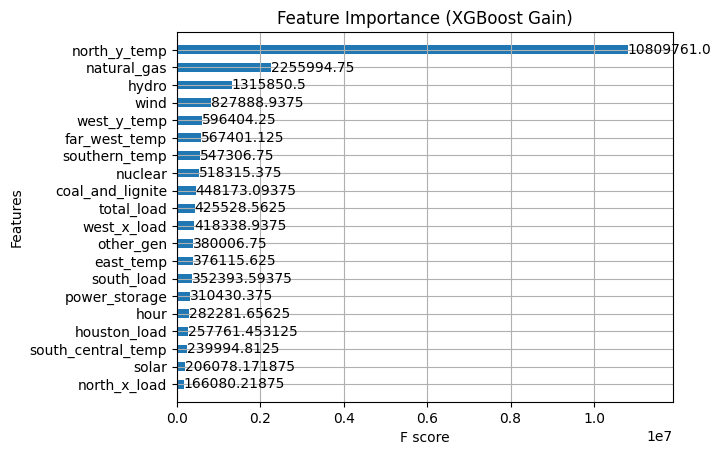

In [21]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

# 删除时间戳
df = df.drop(columns=['interval_start_local', 'date'])

# 划分特征和标签
X = df.drop(columns=['lmp_HB_BUSAVG'])
y = df['lmp_HB_BUSAVG']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# 画 feature importance
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)
plt.title("Feature Importance (XGBoost Gain)")
plt.show()
